In [46]:
#!/usr/bin/env python
# -*- encoding: utf-8 -*-
'''
@File    :   多臂老虎机.ipynb
@Time    :   2025/06/03 20:08:11
@Author  :   Neutrin 
'''

# here put the import lib
import numpy as np
import matplotlib.pyplot as plt


In [47]:
class Bandit:
    def __init__(self,K):
        self.probs = np.random.uniform(size=K) # 随机生成每个臂的概率
        self.best_idx = np.argmax(self.probs)
        self.best_prob = self.probs[self.best_idx] # 最优臂的概率
        self.K = K
    
    def step(self,k):
        if np.random.rand() < self.probs[k]:
            return 1
        else:
            return 0

np.random.seed(42)
K = 10
Bandit10 = Bandit(K)
print ("随机生成了一个%d臂老虎机" % K)
print ("每个臂的概率为：", Bandit10.probs)
print ("最优臂为：", Bandit10.best_idx, "，概率为：", Bandit10.best_prob)

随机生成了一个10臂老虎机
每个臂的概率为： [0.37454012 0.95071431 0.73199394 0.59865848 0.15601864 0.15599452
 0.05808361 0.86617615 0.60111501 0.70807258]
最优臂为： 1 ，概率为： 0.9507143064099162


In [48]:
class Solver:
    def __init__(self, bandit):
        self.bandit = bandit
        self.counts = np.zeros(self.bandit.K)
        self.regret = 0.
        self.actions = []
        self.regrets = []
        
    def update_regret(self, k):
        self.regret += self.bandit.best_prob - self.bandit.probs[k] 
        self.regrets.append(self.regret)
        
    def run_one_step(self):
        raise NotImplementedError("run_one_step must be implemented in subclass")
    
    def run(self, num_steps):
        for _ in range(num_steps):
            k = self.run_one_step()
            self.counts[k] += 1
            self.actions.append(k)
            self.update_regret(k)
            

In [49]:
class EpsilonGreedy(Solver):
    """ epsilon贪婪算法,继承Solver类 """
    def __init__(self, bandit, epsilon=0.01, init_prob=1.0):
        super(EpsilonGreedy, self).__init__(bandit)
        self.epsilon = epsilon
        #初始化拉动所有拉杆的期望奖励估值
        self.estimates = np.array([init_prob] * self.bandit.K)

    def run_one_step(self):
        if np.random.random() < self.epsilon:
            k = np.random.randint(0, self.bandit.K)  # 随机选择一根拉杆
        else:
            k = np.argmax(self.estimates)  # 选择期望奖励估值最大的拉杆
            
        r = self.bandit.step(k)  # 得到本次动作的奖励
        
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])
        
        return k
    

epsilon-贪婪算法的累积懊悔为： 28.44034123241696


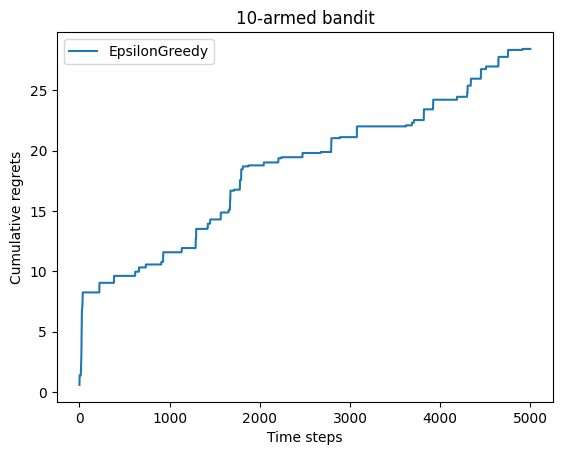

In [57]:
def plot_results(solvers, solver_names):
    """生成累积懊悔随时间变化的图像。输入solvers是一个列表,列表中的每个元素是一种特定的策略。
    而solver_names也是一个列表,存储每个策略的名称"""
    for idx, solver in enumerate(solvers):
        time_list = range(len(solver.regrets))
        plt.plot(time_list, solver.regrets, label=solver_names[idx])
    plt.xlabel('Time steps')
    plt.ylabel('Cumulative regrets')
    plt.title('%d-armed bandit' % solvers[0].bandit.K)
    plt.legend()
    plt.show()


np.random.seed(1)
epsilon_greedy_solver = EpsilonGreedy(Bandit10, epsilon=0.01)
epsilon_greedy_solver.run(5000)
print('epsilon-贪婪算法的累积懊悔为：', epsilon_greedy_solver.regret)
plot_results([epsilon_greedy_solver], ["EpsilonGreedy"])

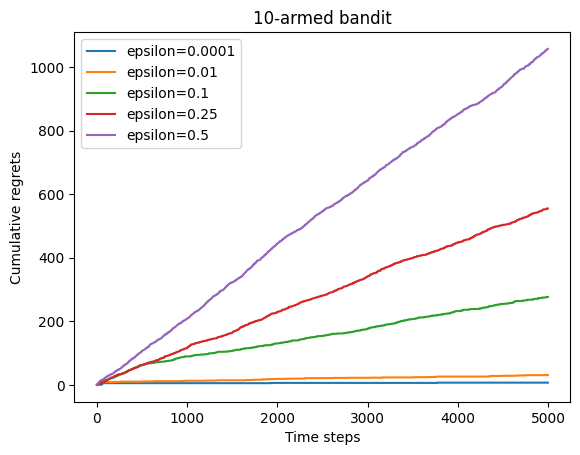

In [58]:
np.random.seed(0)
epsilons = [1e-4, 0.01, 0.1, 0.25, 0.5]
epsilon_greedy_solver_list = [
    EpsilonGreedy(Bandit10, epsilon=e) for e in epsilons
]
epsilon_greedy_solver_names = ["epsilon={}".format(e) for e in epsilons]
for solver in epsilon_greedy_solver_list:
    solver.run(5000)

plot_results(epsilon_greedy_solver_list, epsilon_greedy_solver_names)

epsilon值衰减的贪婪算法的累积懊悔为： 9.989353503976956


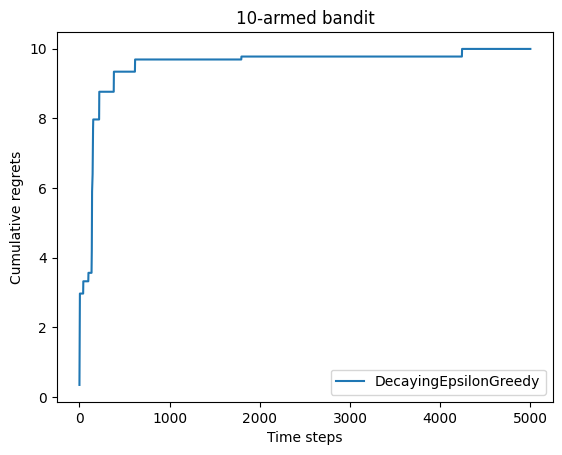

In [59]:
class DecayingEpsilonGreedy(Solver):
    """ epsilon值随时间衰减的epsilon-贪婪算法,继承Solver类 """
    def __init__(self, bandit, init_prob=1.0):
        super(DecayingEpsilonGreedy, self).__init__(bandit)
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.total_count = 0

    def run_one_step(self):
        self.total_count += 1
        if np.random.random() < 1 / self.total_count:  # epsilon值随时间衰减
            k = np.random.randint(0, self.bandit.K)
        else:
            k = np.argmax(self.estimates)

        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])

        return k


np.random.seed(1)
decaying_epsilon_greedy_solver = DecayingEpsilonGreedy(Bandit10)
decaying_epsilon_greedy_solver.run(5000)
print('epsilon值衰减的贪婪算法的累积懊悔为：', decaying_epsilon_greedy_solver.regret)
plot_results([decaying_epsilon_greedy_solver], ["DecayingEpsilonGreedy"])

上置信界算法的累积懊悔为： 125.34523643058462


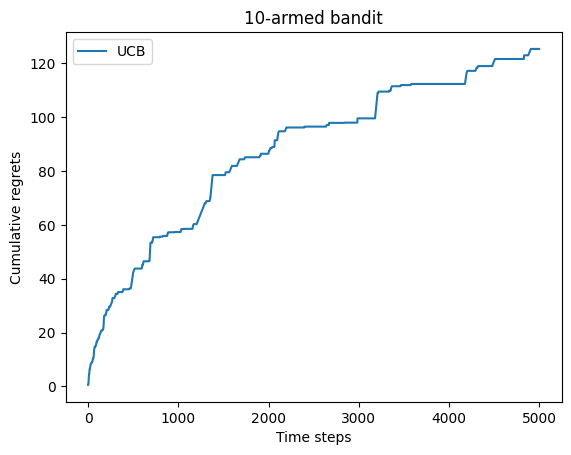

In [69]:
class UCB(Solver):
    """ UCB算法,继承Solver类 """
    def __init__(self, bandit, coef, init_prob=1.0):
        super(UCB, self).__init__(bandit)
        self.total_count = 0
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.coef = coef

    def run_one_step(self):
        self.total_count += 1
        ucb = self.estimates + self.coef * np.sqrt(
            np.log(self.total_count) / (2 * (self.counts + 1)))  # 计算上置信界
        k = np.argmax(ucb)  # 选出上置信界最大的拉杆
        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])
        return k


np.random.seed(45)
coef = 1  # 控制不确定性比重的系数
UCB_solver = UCB(Bandit10, coef)
UCB_solver.run(5000)
print('上置信界算法的累积懊悔为：', UCB_solver.regret)
plot_results([UCB_solver], ["UCB"])

汤普森采样算法的累积懊悔为： 22.92250823023943


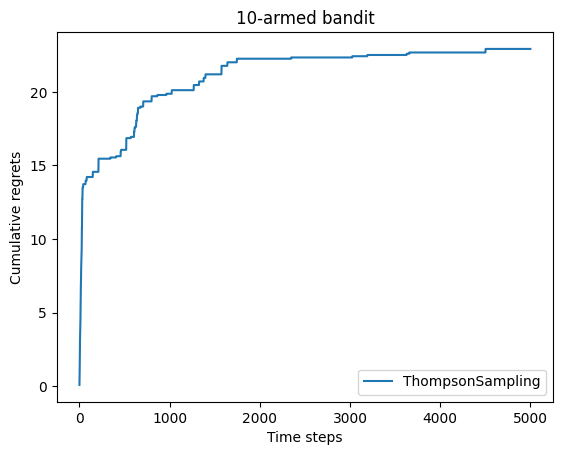

In [71]:
class ThompsonSampling(Solver):
    """ 汤普森采样算法,继承Solver类 """
    def __init__(self, bandit):
        super(ThompsonSampling, self).__init__(bandit)
        self._a = np.ones(self.bandit.K)  # 列表,表示每根拉杆奖励为1的次数
        self._b = np.ones(self.bandit.K)  # 列表,表示每根拉杆奖励为0的次数

    def run_one_step(self):
        samples = np.random.beta(self._a, self._b)  # 按照Beta分布采样一组奖励样本
        k = np.argmax(samples)  # 选出采样奖励最大的拉杆
        r = self.bandit.step(k)

        self._a[k] += r  # 更新Beta分布的第一个参数
        self._b[k] += (1 - r)  # 更新Beta分布的第二个参数
        return k


np.random.seed(1)
thompson_sampling_solver = ThompsonSampling(Bandit10)
thompson_sampling_solver.run(5000)
print('汤普森采样算法的累积懊悔为：', thompson_sampling_solver.regret)
plot_results([thompson_sampling_solver], ["ThompsonSampling"])